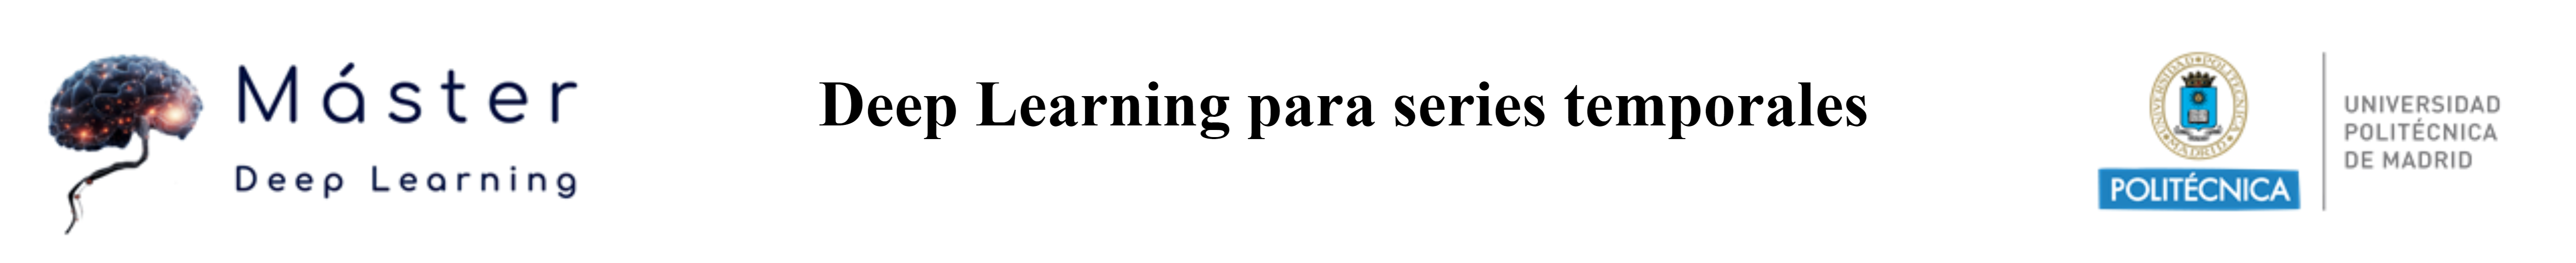

In [4]:
#! pip install pmdarima statsmodels matplotlib numpy pandas seaborn

# Cedasticity

Homoscedasticity refers to **constant variance** in the errors of a time series model. In ARIMA, this means that the residuals (errors) do not show increasing or decreasing variance over time. If the residuals have non-constant variance (**heteroscedasticity**), we might need to use a GARCH model instead.




> References
> [ Homocedasticity | Eng ] (https://sscc.wisc.edu/sscc/pubs/RegDiag-R/homoscedasticity.html#statistical-tests-2 )
>
> [ Homocedasticidad | Esp ] (https://cienciadedatos.net/documentos/9_homogeneidad_de_varianza_homocedasticidad.html
>
> [ GARCH | Eng ](http://sciencedirect.com/topics/social-sciences/generalized-autoregressive-conditional-heteroscedasticity)



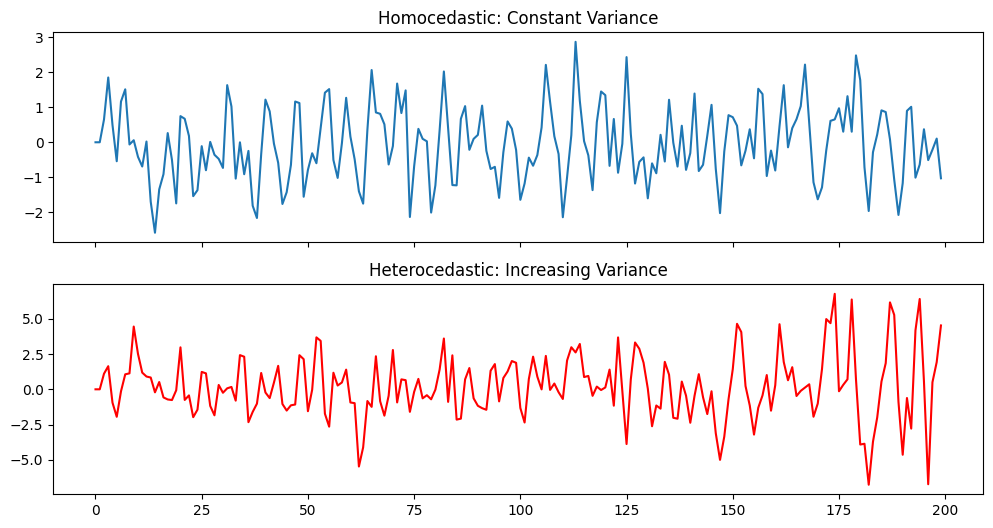

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Función para generar series homocedásticas y heterocedásticas
def generate_series(n=200):
    np.random.seed(42)

    # Homocedástica: AR(2) con ruido blanco constante
    noise_hom = np.random.normal(scale=1, size=n)
    y_hom = np.zeros(n)
    for t in range(2, n):
        y_hom[t] = 0.5 * y_hom[t-1] - 0.3 * y_hom[t-2] + noise_hom[t]  # AR(2)

    # Heterocedástica: AR(2) con varianza creciente
    noise_het = np.random.normal(scale=1 + np.linspace(0, 2, n), size=n)
    y_het = np.zeros(n)
    for t in range(2, n):
        y_het[t] = 0.5 * y_het[t-1] - 0.3 * y_het[t-2] + noise_het[t]  # AR(2)

    # Graficar ambas series
    fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
    ax[0].plot(y_hom, label="Homocedastic Series")
    ax[0].set_title("Homocedastic: Constant Variance")
    ax[1].plot(y_het, label="Heterocedastic Series", color='red')
    ax[1].set_title("Heterocedastic: Increasing Variance")

    plt.show()

    return y_hom, y_het

# Generar y guardar las series
y_hom, y_het = generate_series()


In [5]:
def plot_rolling_variance(y_hom, y_het):
  window_size = 20

  var_hom = pd.Series(y_hom).rolling(window=window_size).var()
  var_het = pd.Series(y_het).rolling(window=window_size).var()
  fig, ax = plt.subplots(1, 2, figsize=(12, 4))
  ax[0].plot(var_hom, label="Rolling variance")
  ax[0].set_title("Y_hom")
  ax[1].plot(var_het, label="Rolling variance", color="red")
  ax[1].set_title("Y_het")
  ax[0].set_xlim(0, len(var_hom))
  ax[1].set_xlim(0, len(var_het))
  max =  np.nanmax(var_het)
  ymax = max +0.04*max
  ax[0].set_ylim(0, ymax)
  ax[1].set_ylim(0, ymax)
  plt.show()

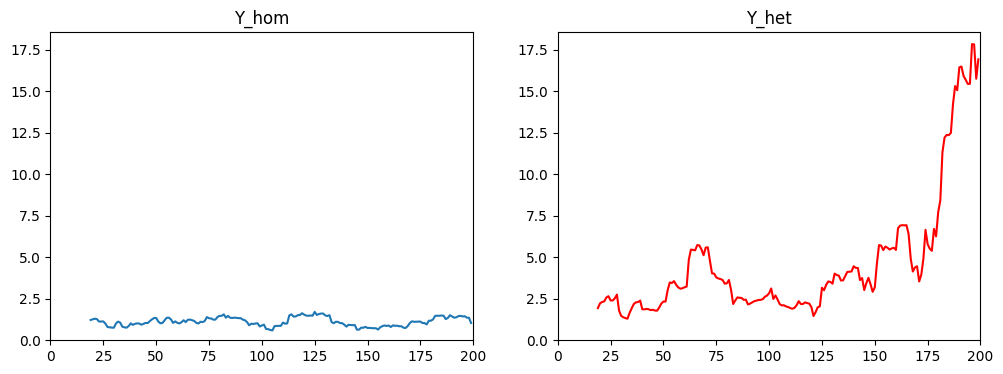

In [6]:
plot_rolling_variance(y_hom, y_het)

## Why Use ARIMA to Analyze Variance?

ARIMA assumes **homoscedasticity** in residuals. If variance is not constant, using ARIMA alone might lead to incorrect confidence intervals. A method like **GARCH** (Generalized Autoregressive Conditional Heteroscedasticity) can be applied to model variance changes over time.

[Reference: ARIMA-GARCH Model | (Esp) ](https://mlpills.dev/series-temporales/modelos-arima-garch/?utm_source=chatgpt.com)

## How can I check if the time series is valid for ARIMA?
The usual application of ARCH test is to use it to know the variance of the errors so that we know if the variance of the errors changes across time or not. But we could also apply it to the original time series, obtaining a classificator as done in the next cell.

> References
> [ Lagrange Multiplicative score test | null hypothesis, p-value ] (https://www.statlect.com/fundamentals-of-statistics/score-test)

In [44]:
from statsmodels.stats.diagnostic import het_arch

def check_homoscedasticity(series, name="Series"):
    arch_test = het_arch(series)
    p_value = arch_test[1]
    print(f"{name}: ARCH Test p-value = {p_value:.5f}")

    if p_value < 0.05:
        print(f"❌ {name} is NOT homoscedastic (variance changes over time). Consider using GARCH.")
    else:
        print(f"✅ {name} is homoscedastic (variance remains constant). ARIMA is appropriate.")

# Checking our simulated series
check_homoscedasticity(y_hom, "Y_hom")
check_homoscedasticity(y_het, "Y_het")

Y_hom: ARCH Test p-value = 0.72477
✅ Y_hom is homoscedastic (variance remains constant). ARIMA is appropriate.
Y_het: ARCH Test p-value = 0.00001
❌ Y_het is NOT homoscedastic (variance changes over time). Consider using GARCH.


## How can I determine good (p,q,d) parameters?
To estimate the values of **p, d, q**, we use statistical tests:
- **\( d \) (Dickey-Fuller test)**: Checks if the series is stationary.
- **\( p \) (PACF plot)**: Identifies autoregressive terms.
- **\( q \) (ACF plot)**: Identifies moving average terms.

[Reference: Auto ARIMA Selection](https://alkaline-ml.com/pmdarima/auto_examples/arima/example_auto_arima.html)
[ Reference: Choosing best q and p] (https://www.baeldung.com/cs/acf-pacf-plots-arma-modeling)

### Determine d with ADF test

The statistical test most employed to verify the stationarity of time series data is the Augmented Dickey-Fuller test.

The hypotheses for this test are:
- $H_0$ (Null hypothesis) = Time series non-stationary
- $H_1$ (Alternative hypothesis) = Time series stationary

We need to define a significance level $\alpha$, generally wet to 0.05. This value is used to compare it with the p-value from the test:

- If $p > \alpha$, we conclude the time series is non-stationary.
- If $p < \alpha$, we conclude the time series is stationary.

To select $d$ we will perform the test on the time series data. If we can conclude that it is stationary, then $d = 0$. If not, we differentiate the time series and add $1$ to $d$ until it gets stationary.

In [8]:
from pmdarima.arima import ADFTest

In [9]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series, name="Series"):
    result = adfuller(series)
    print(f"{name}: ADF Statistic = {result[0]:.5f}, p-value = {result[1]:.5f}")

    if result[1] < 0.05:
        print(f"✅ {name} is stationary (d=0)")
    else:
        print(f"❌ {name} is NOT stationary (d=1 needed)")

# Revisar si d=1 es necesario
check_stationarity(y_hom, "Homocedastic Series")
check_stationarity(y_het, "Heterocedastic Series")

Homocedastic Series: ADF Statistic = -6.08591, p-value = 0.00000
✅ Homocedastic Series is stationary (d=0)
Heterocedastic Series: ADF Statistic = -9.98330, p-value = 0.00000
✅ Heterocedastic Series is stationary (d=0)


In [10]:
def estimate_d(series, alpha=0.05, verbose=False):
    adf_test = ADFTest(alpha=alpha)
    d = -1
    dodiff = True
    while dodiff:
      d += 1
      dodiff = adf_test.should_diff(series)[1]
      series = pd.Series(np.diff(series)).dropna()
    return d


In [11]:
print("y_hom")
print(estimate_d(y_hom, 0.05, 1))
print("y_het_1")
print(estimate_d(y_het, 0.05, 1))

y_hom
0
y_het_1
0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

In [12]:
import pmdarima as pm

In [13]:
d_y_hom = pm.arima.ndiffs(y_hom, test='adf', alpha = 0.05)
d_y_het = pm.arima.ndiffs(y_het, test='adf', alpha = 0.05)
print(f"d_y_hom: {d_y_hom}")
print(f"d_y_het: {d_y_het}")

d_y_hom: 0
d_y_het: 0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

In [14]:
d_y_hom = pm.arima.ndiffs(y_hom, test='pp', alpha = 0.05)
d_y_het = pm.arima.ndiffs(y_het, test='pp', alpha = 0.05)
print(f"d_y_hom: {d_y_hom}")
print(f"d_y_het: {d_y_het}")

d_y_hom: 0
d_y_het: 0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

In [15]:
d_y_hom = pm.arima.ndiffs(y_hom, test='kpss', alpha = 0.05)
d_y_het = pm.arima.ndiffs(y_het, test='kpss', alpha = 0.05)
print(f"d_y_hom: {d_y_hom}")
print(f"d_y_het: {d_y_het}")

d_y_hom: 0
d_y_het: 0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Makes sense as 'd' is used to make the series mean-stationary and our series mean is more or less stationary. Let's check p and q.

### ACF and PACF: Selecting p and q for ARIMA

ACF and PACF plots help determine the order of the autoregressive ($p$) and moving average ($q$) terms.

#### What do the plots represent?
- **ACF (Autocorrelation Function):** Shows how past values of the series are correlated with the current values.
- **PACF (Partial Autocorrelation Function):** Shows the correlation after removing the effect of intermediate lags.

In these plots:
- The **X-axis represents the lags** (previous time steps).
- The **Y-axis shows the correlation**.
- Each bar represents the correlation at a specific lag.

#### For determining $p$ (the AR order), look at the PACF plot:
- Identify **the last significant lag before the function drops close to zero**.
- This means the **first lag where the bar is no longer significant** (i.e., it falls within the blue shaded region).
- That number is $p$.

#### For determining $q$ (the MA order), look at the ACF plot:
- Use the same criterion: **find the last significant lag before the function drops close to zero**.
- That number is $q$.

#### What does "significant" mean?
- ACF and PACF plots usually include a **blue shaded region** or **horizontal lines** (which represent a 95% confidence interval).
- If a bar **extends above this blue region**, it is considered **significant**.
- When the bars **suddenly become insignificant**, select **the last significant lag before the drop**.

This method allows systematic selection of $p$ and $q$, helping to configure an ARIMA model effectively.


Optimal d: 0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

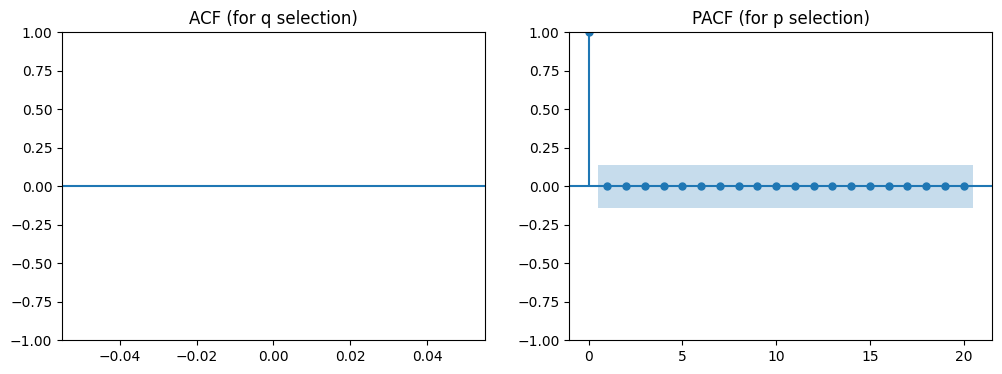

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Optimal d: 0


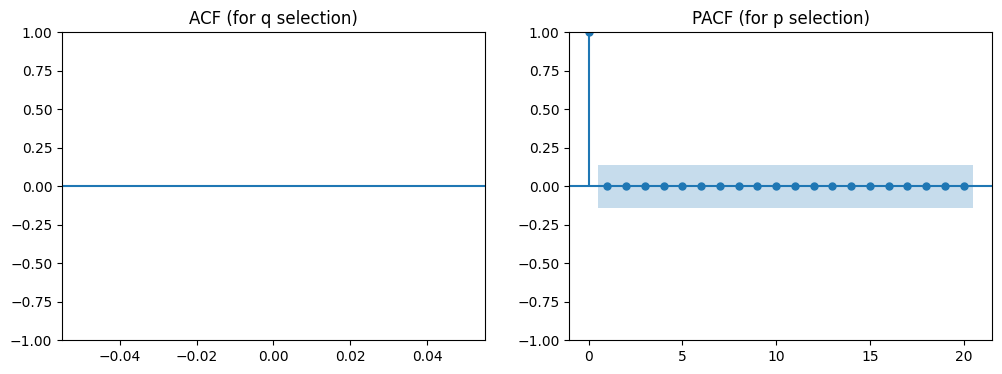

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def estimate_p_q(series):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    plot_acf(series.dropna(), ax=axes[0], lags=20)
    plot_pacf(series.dropna(), ax=axes[1], lags=20, method="ywm")
    axes[0].set_title("ACF (for q selection)")
    axes[1].set_title("PACF (for p selection)")
    plt.show()

# Applying ACF & PACF plots
d_opt = estimate_d(pd.Series(y_hom))
print(f"Optimal d: {d_opt}")
estimate_p_q(pd.Series(y_hom).diff(d_opt).dropna())
d_opt = estimate_d(pd.Series(y_het))
print(f"Optimal d: {d_opt}")
estimate_p_q(pd.Series(y_het).diff(d_opt).dropna())

Seems that p = 1 d = 0 q = 0 is the best option for all the cases.

In [17]:
def predict_and_plot(df, arima_model, horizon = 24):
  arima_forecast = arima_model.forecast(steps=horizon)
  # Create DataFrame of predictions
  future_time = np.arange(len(df), len(df) + horizon)
  forecast_df = pd.DataFrame({"Time": future_time, "ARIMA": arima_forecast})

  # Plot results
  plt.figure(figsize=(12, 5))
  plt.plot(df["Time"], df["Value"], label="Original", color="black")
  plt.plot(forecast_df["Time"], forecast_df["ARIMA"], label="ARIMA", linestyle="dashed")
  plt.title("Prediction")
  plt.legend()
  plt.show()

def series_to_df(size = None, y = None):
  if size is None:
    df = pd.DataFrame({"Time": np.arange(len(y)), "Value": y})
  else:
    np.random.seed(42)
    n = 200
    t = np.arange(size)
    y_trend = 0.5 * t + 5 * np.sin(2 * np.pi * t / 12) + np.random.randn(n) * 2  # Tendencia + estacionalidad
    df = pd.DataFrame({"Time": t, "Value": y_trend})
  return df

In [18]:
from statsmodels.tsa.arima.model import ARIMA

In [19]:
? ARIMA

In [20]:
arima_hom = ARIMA(y_hom, order=(1,0,0)).fit()
arima_het = ARIMA(y_het, order=(1,0,0)).fit()

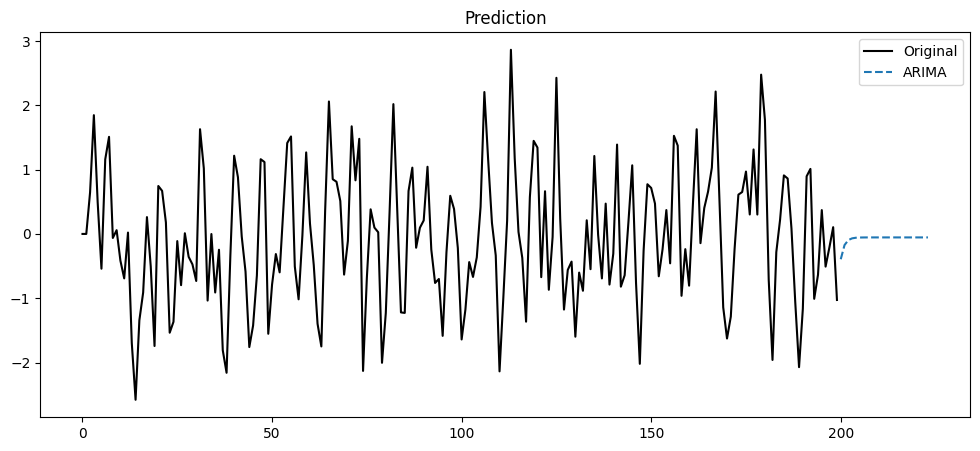

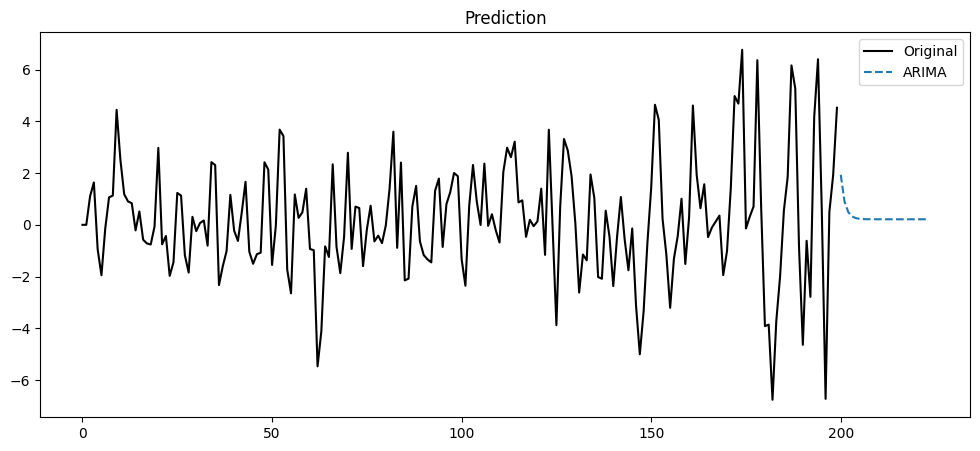

In [21]:
predict_and_plot(series_to_df(None, y_hom), arima_hom)
predict_and_plot(series_to_df(None, y_het), arima_het)

Not really good... And with less volatility?

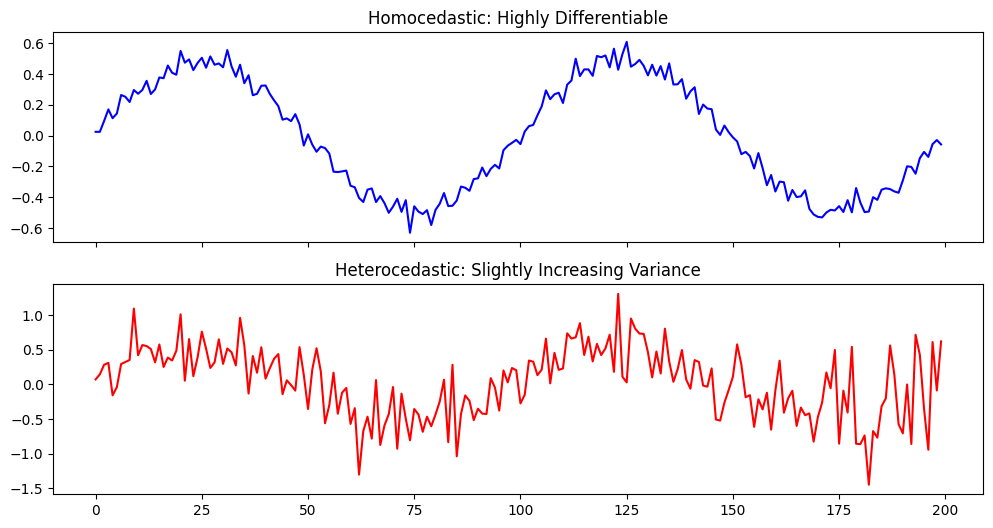

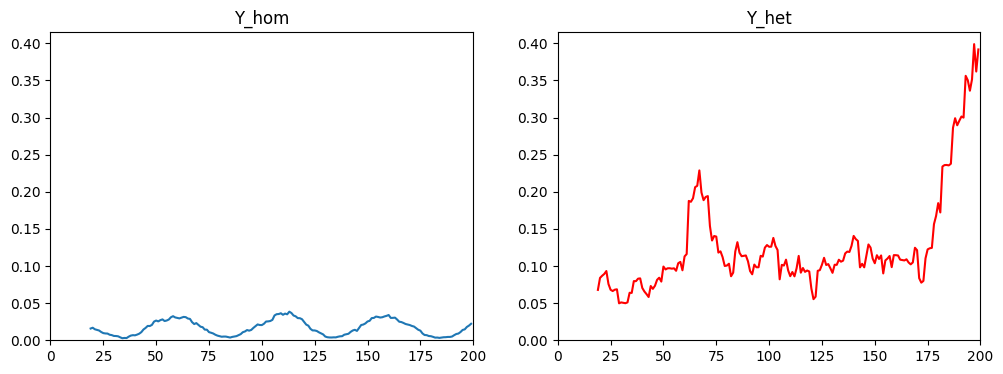

In [54]:
def generate_smoother_sample(n=200):
    np.random.seed(42)

    # Homocedástica: Tendencia suave con ruido constante
    x = np.linspace(0, 4 * np.pi, n)  # Espaciado uniforme para suavidad
    trend_hom = np.sin(x) * 0.5  # Suavidad con seno
    noise_hom = np.random.normal(scale=0.05, size=n)  # Ruido muy bajo y constante
    y_hom = trend_hom + noise_hom  # Suavidad + poco ruido

    # Heterocedástica: Similar, pero con ruido creciente
    noise_het = np.random.normal(scale=0.2 + np.linspace(0, 0.3, n), size=n)  # Ruido creciente
    y_het = trend_hom + noise_het  # Se mantiene la misma tendencia, pero con mayor varianza

    # Graficar ambas series
    fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
    ax[0].plot(y_hom, label="Smooth Homocedastic Series", color="blue")
    ax[0].set_title("Homocedastic: Highly Differentiable")
    ax[1].plot(y_het, label="Smooth Heterocedastic Series", color="red")
    ax[1].set_title("Heterocedastic: Slightly Increasing Variance")

    plt.show()

    return y_hom, y_het

# Generar nuevas series derivables
y_hom_smooth, y_het_smooth = generate_smoother_sample()
plot_rolling_variance(y_hom_smooth, y_het_smooth)

In [55]:
# Verificar si las nuevas series son homocedásticas
check_homoscedasticity(y_hom_smooth, "Homocedastic Series")
check_homoscedasticity(y_het_smooth, "Heterocedastic Series")

Homocedastic Series: ARCH Test p-value = 0.00000
❌ Homocedastic Series is NOT homoscedastic (variance changes over time). Consider using GARCH.
Heterocedastic Series: ARCH Test p-value = 0.27914
✅ Heterocedastic Series is homoscedastic (variance remains constant). ARIMA is appropriate.


In [56]:
check_stationarity(y_hom_smooth, "Homocedastic Series")
check_stationarity(y_het_smooth, "Heterocedastic Series")

Homocedastic Series: ADF Statistic = -6.44911, p-value = 0.00000
✅ Homocedastic Series is stationary (d=0)
Heterocedastic Series: ADF Statistic = -2.07893, p-value = 0.25307
❌ Heterocedastic Series is NOT stationary (d=1 needed)


In [59]:
d_y_hom_smooth = pm.arima.ndiffs(y_hom_smooth, test="adf", alpha=0.05)
d_y_het_smooth = pm.arima.ndiffs(y_het_smooth, test="adf", alpha=0.05)

print(f"d_y_hom_smooth: {d_y_hom_smooth}")
print(f"d_y_het_smooth: {d_y_het_smooth}")

d_y_hom_smooth: 2
d_y_het_smooth: 1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

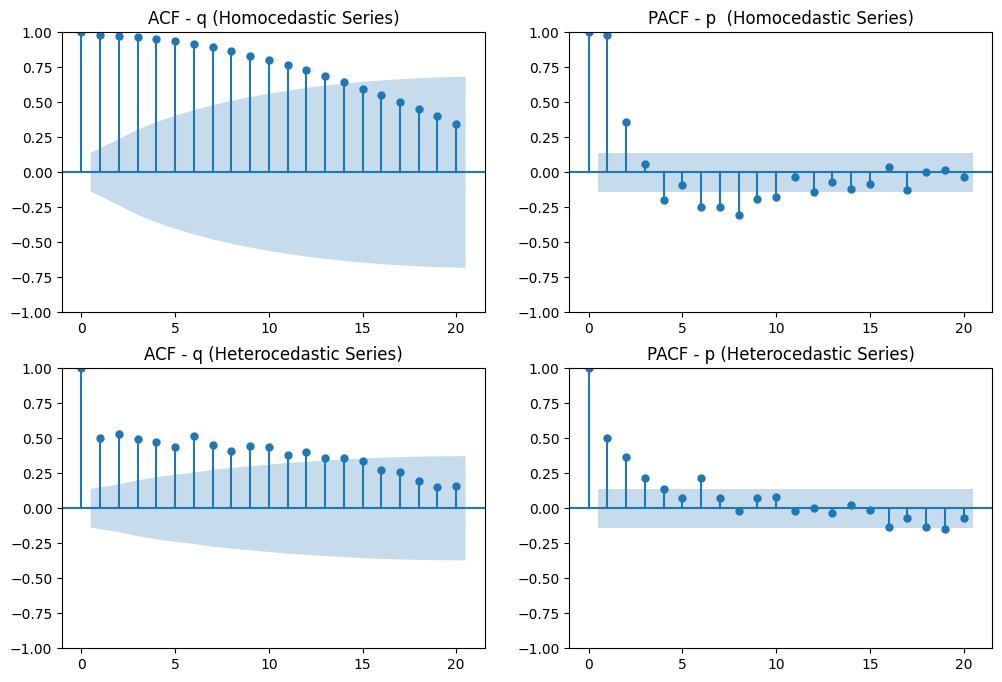

In [58]:
import statsmodels.api as sm

fig, ax = plt.subplots(2, 2, figsize=(12, 8))

sm.graphics.tsa.plot_acf(y_hom_smooth, lags=20, ax=ax[0, 0])
ax[0, 0].set_title("ACF - q (Homocedastic Series)")
sm.graphics.tsa.plot_pacf(y_hom_smooth, lags=20, ax=ax[0, 1])
ax[0, 1].set_title("PACF - p  (Homocedastic Series)")

sm.graphics.tsa.plot_acf(y_het_smooth, lags=20, ax=ax[1, 0])
ax[1, 0].set_title("ACF - q (Heterocedastic Series)")
sm.graphics.tsa.plot_pacf(y_het_smooth, lags=20, ax=ax[1, 1])
ax[1, 1].set_title("PACF - p (Heterocedastic Series)")

plt.show()


In [83]:
# Ultimo por fuera de lo azul
print(f"d_y_hom_smooth: {d_y_hom_smooth}")
print(f"d_y_het_smooth: {d_y_het_smooth}")

pdq_hom = 3, d_y_hom_smooth, 14
pdq_het = 7, d_y_het_smooth, 12

arima_hom_smooth = ARIMA(y_hom_smooth, order=pdq_hom).fit()
arima_het_smooth = ARIMA(y_het_smooth, order=pdq_het).fit()

d_y_hom_smooth: 2
d_y_het_smooth: 1


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [79]:
def predict_and_plot(df, arima_model = None, ets_model = None, horizon = 24, title = "Comparación de Predicciones ARIMA vs ETS" ):
  # Create DataFrame of predictions
  future_time = np.arange(len(df), len(df) + horizon)
  if arima_model is not None:
    arima_forecast = arima_model.forecast(steps=horizon)
  if ets_model is not None:
    ets_forecast = ets_model.forecast(steps=horizon)
  if arima_model is not None and ets_model is not None:
    forecast_df = pd.DataFrame({"Time": future_time, "ARIMA": arima_forecast, "ETS": ets_forecast})
  elif arima_model is not None:
    forecast_df = pd.DataFrame({"Time": future_time, "ARIMA": arima_forecast})
  elif ets_model is not None:
    forecast_df = pd.DataFrame({"Time": future_time, "ETS": ets_forecast})
  # Plot results
  plt.figure(figsize=(12, 5))
  plt.plot(df["Time"], df["Value"], label="Serie Original", color="black")
  if arima_model is not None: plt.plot(forecast_df["Time"], forecast_df["ARIMA"], label="Predicción ARIMA", linestyle="dashed")
  if ets_model is not None: plt.plot(forecast_df["Time"], forecast_df["ETS"], label="Predicción ETS", linestyle="dotted")
  plt.title(title)
  plt.legend()
  plt.show()

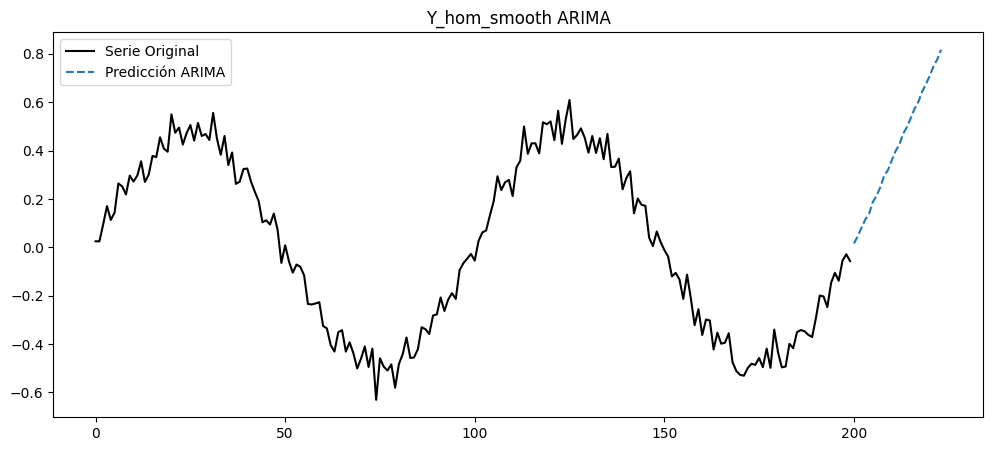

ARIMA((3, 2, 14)) AIC: -554.0897851022766


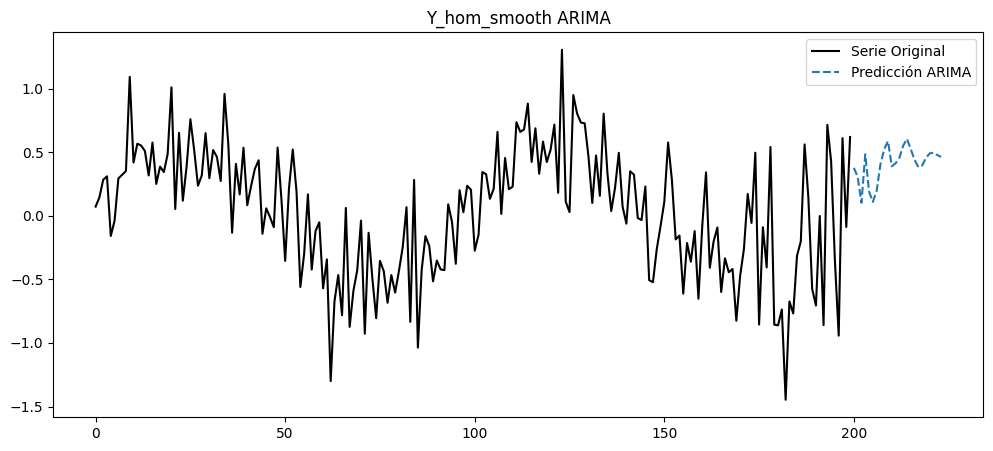

ARIMA((7, 1, 12)) AIC: 201.29592035121635


In [86]:
y_hom_smooth_df = series_to_df(size = None, y = y_hom_smooth)
y_het_smooth_df = series_to_df(size = None, y = y_het_smooth)
predict_and_plot(y_hom_smooth_df, arima_hom_smooth, None, 24, "Y_hom_smooth ARIMA") # Use the DataFrame here
print(f"ARIMA({pdq_hom}) AIC: {arima_hom_smooth.aic}")
predict_and_plot(y_het_smooth_df, arima_het_smooth, None, 24, "Y_hom_smooth ARIMA") # Use the DataFrame here
print(f"ARIMA({pdq_het}) AIC: {arima_het_smooth.aic}")

### Using auto_arima for Automatic Parameter Selection

Instead of manually selecting \( p, d, q \), we can use `auto_arima()` to find the best ARIMA model automatically.


In [90]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore", module="sklearn")

In [91]:
auto_hom = auto_arima(y_hom_smooth, seasonal=True, trace=False).order
auto_het = auto_arima(y_het_smooth, seasonal=True, trace=False).order
print(auto_hom)
print(auto_het)
arima_hom_smooth_auto = ARIMA(y_hom_smooth, order=auto_hom).fit()
arima_het_smooth_auto = ARIMA(y_het_smooth, order=auto_het).fit()

(1, 1, 2)
(0, 1, 1)


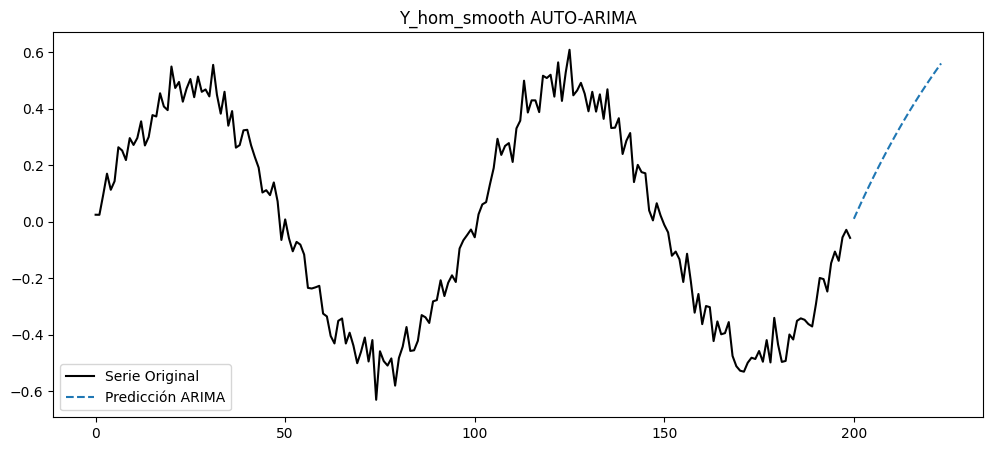

ARIMA((1, 1, 2)) AIC: -568.1259191113015


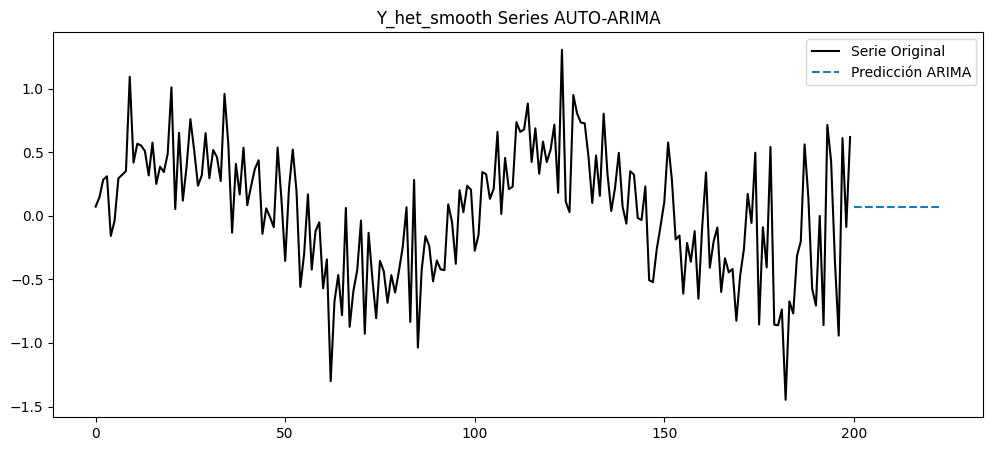

ARIMA((0, 1, 1)) AIC: 185.76240880941788


In [92]:
predict_and_plot(y_hom_smooth_df, arima_hom_smooth_auto, None, 24, "Y_hom_smooth AUTO-ARIMA")
print(f"ARIMA({auto_hom}) AIC: {arima_hom_smooth_auto.aic}")
predict_and_plot(y_het_smooth_df, arima_het_smooth_auto, None, 24, "Y_het_smooth Series AUTO-ARIMA")
print(f"ARIMA({auto_het}) AIC: {arima_het_smooth_auto.aic}")

Testing with trend & comparing

In [93]:
# Lista de series a evaluar
series_list = {
    "y_hom": pd.Series(y_hom),
    "y_het": pd.Series(y_het)
}

# Diccionario para almacenar los resultados
arima_params = {}

# Aplicar auto_arima y extraer (p, d, q)
for name, series in series_list.items():
    model = auto_arima(series, seasonal=True, trace=False)
    p, d, q = model.order
    arima_params[name] = {"p": p, "d": d, "q": q}

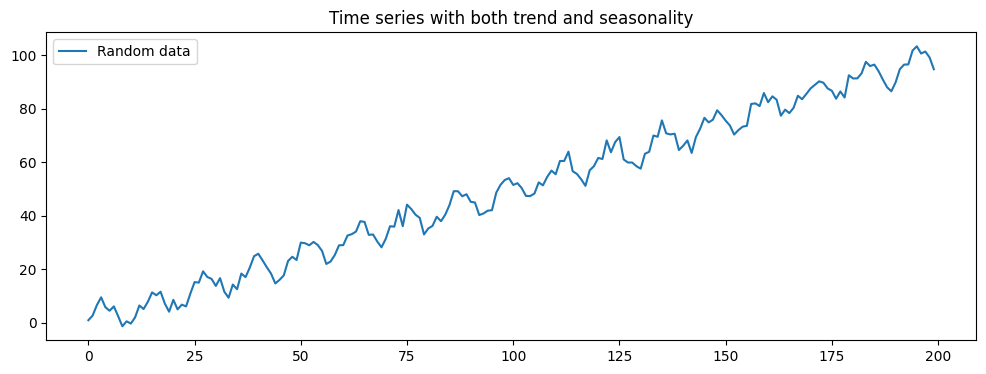

In [94]:
def plot_df(df, title):
  plt.figure(figsize=(12, 4))
  plt.plot(df["Time"], df["Value"], label="Random data")
  plt.title(title)
  plt.legend()
  plt.show()
df_trend = series_to_df(size = 200)
plot_df(df_trend, "Time series with both trend and seasonality")
#df_trend.head()

In [95]:
params_trend = auto_arima(df_trend["Value"], seasonal=True, trace=True).order

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.88 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1032.985, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1032.888, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1033.324, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1035.221, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1031.862, Time=1.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1032.672, Time=1.95 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1033.658, Time=0.80 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1034.067, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1029.818, Time=0.21 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.75 sec


/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(3,1,2)(0,0,0)[0] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/pmdarima/arima/arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "/usr/local/lib/python3.11/dist-packages/pmdarima/arima/arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pmdarima/arima/arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/mlemodel.py", line 705, in fit
    mlefit = super().fit(start_pa

 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=nan sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1019.106, Time=0.13 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1008.843, Time=0.17 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.94 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=1016.172, Time=0.07 sec

Best model:  ARIMA(5,1,0)(0,0,0)[0] intercept
Total fit time: 7.873 seconds


#### AIC, BIC and ETS models

In [96]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [97]:
arima_trend = SARIMAX(df_trend["Value"], order=params_trend).fit()
params = (arima_params['y_hom']['p'], arima_params['y_hom']['d'], arima_params['y_hom']['q'])
arima_hom = SARIMAX(y_hom, order=params).fit()
params = (arima_params['y_het']['p'], arima_params['y_het']['d'], arima_params['y_het']['q'])
arima_het = SARIMAX(y_het, order=params).fit()
ets_model_trend = ExponentialSmoothing(df_trend["Value"], seasonal="additive", seasonal_periods=12).fit()
ets_model_hom = ExponentialSmoothing(y_hom, seasonal="additive", seasonal_periods=12).fit()
ets_model_het = ExponentialSmoothing(y_het, seasonal="additive", seasonal_periods=12).fit()

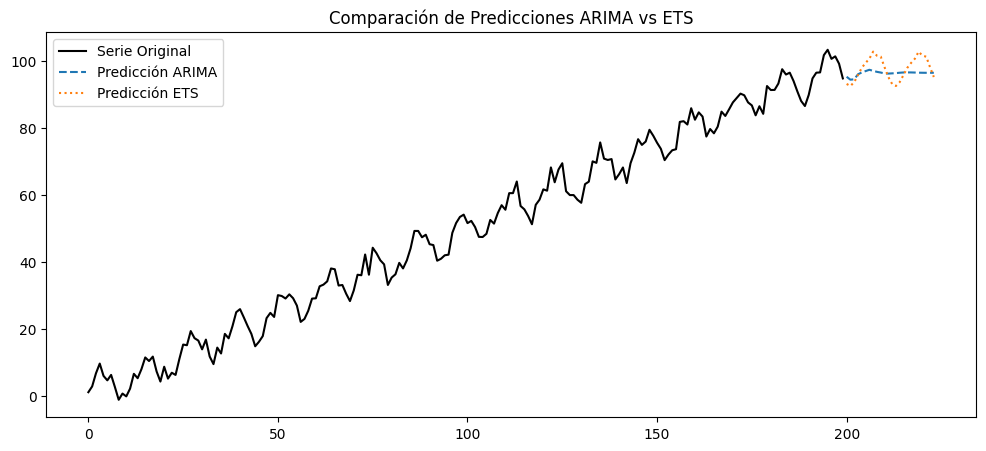

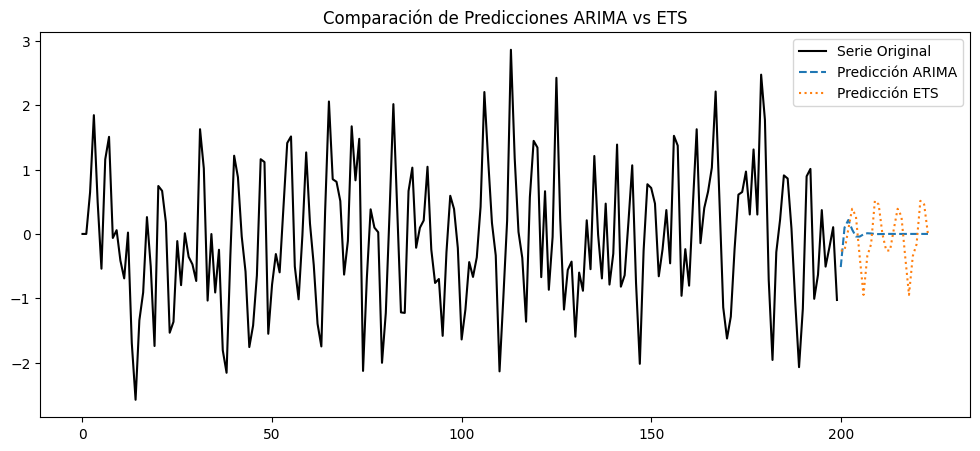

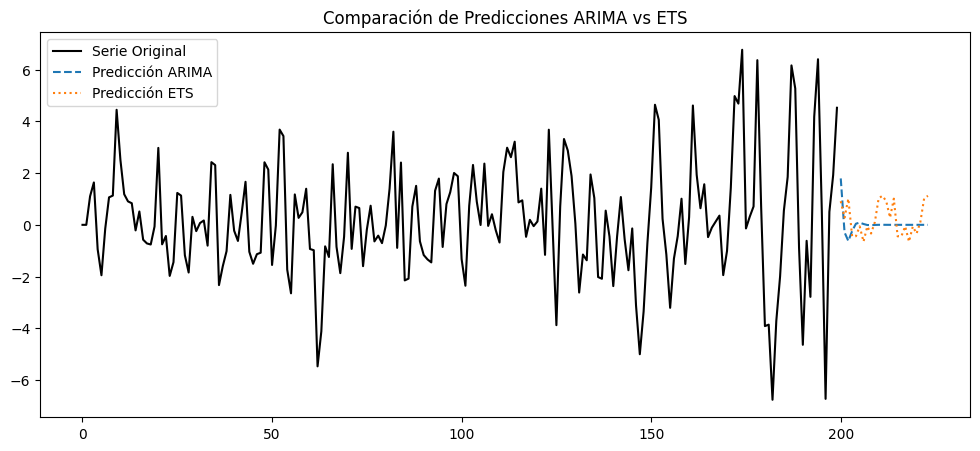

In [98]:
# Predictions

predict_and_plot(df_trend, arima_trend, ets_model_trend)
predict_and_plot(series_to_df(None, y_hom), arima_hom, ets_model_hom)
predict_and_plot(series_to_df(None, y_het), arima_het, ets_model_het)

## What are AIC and BIC?

AIC (**Akaike Information Criterion**) and BIC (**Bayesian Information Criterion**) are metrics used to compare different statistical models.

Both measure **how well a model fits the data** while penalizing model complexity to avoid overfitting.

- **AIC**: Prioritizes predictive accuracy, allowing slightly more complex models.
- **BIC**: Stricter penalty for complexity, favoring simpler models when data size increases.

> References
>
>  [A new look at the statistical model identification*. IEEE Transactions on Automatic Control.](https://ieeexplore.ieee.org/document/1100705)
>
> [Estimating the dimension of a model](https://www.jstor.org/stable/2958889?seq=1)

### AIC Measure

**AIC (Akaike Information Criterion)** measures the trade-off between goodness of fit and model complexity.

- **Lower AIC is better**: The model balances accuracy and simplicity.
- It allows slightly more complex models if they improve likelihood.
- **Good for predictive models** because it selects the model with the best generalization ability.

⚠ **AIC does not account for sample size**, meaning it might favor complex models when data is large.

### BIC Measure

**BIC (Bayesian Information Criterion)** is similar to AIC but **penalizes complexity more strongly**.

- **Lower BIC is better**: A simpler model that still fits well is preferred.
- **Better for model selection** when the goal is to find the best underlying structure.
- **Takes sample size into account**, favoring simpler models as \( N \) increases.

**Note:** If **AIC and BIC select different models**, BIC will choose the simpler one.

### Summary
## 📌 How to interpret AIC and BIC results?

When comparing models:
- Lower AIC/BIC means a better model
- If two models have similar AIC/BIC, prefer the simpler one
- If models differ greatly, prefer the one with the lowest value

**Which one should I follow?**
According to [Model selection for ecologists: the worldviews of AIC and BIC, pg. 634](https://www.jstor.org/stable/43495189?seq=4), for selecting prediction models you should may use **AIC**.

> References
>
> [ Model selection and mltimodel inference: A practical information.theoretic Approach ](https://link.springer.com/book/10.1007/b97636)


## Comparing AIC and BIC

In [99]:
print(f"ARIMA AIC: {arima_trend.aic}, BIC: {arima_trend.bic}")
print(f"ETS AIC: {ets_model_trend.aic}, BIC: {ets_model_trend.bic}")
# Much better ETS than ARIMA

ARIMA AIC: 1016.1719333370789, BIC: 1035.931762285426
ETS AIC: 356.85923286435127, BIC: 403.03567599602377


In [100]:
print(f"ARIMA AIC: {arima_hom.aic}, BIC: {arima_hom.bic}")
print(f"ETS AIC: {ets_model_hom.aic}, BIC: {ets_model_hom.bic}")

ARIMA AIC: 543.7062712642212, BIC: 553.6012233638653
ETS AIC: 14.305436868670679, BIC: 60.481880000343196


In [101]:
print(f"ARIMA AIC: {arima_het.aic}, BIC: {arima_het.bic}")
print(f"ETS AIC: {ets_model_het.aic}, BIC: {ets_model_het.bic}")

ARIMA AIC: 848.8059988678774, BIC: 858.7009509675215
ETS AIC: 334.98310330625065, BIC: 381.15954643792315


Seems all previous time series were too bad for Arima. Let's check a more "realistic" one (less volatility)

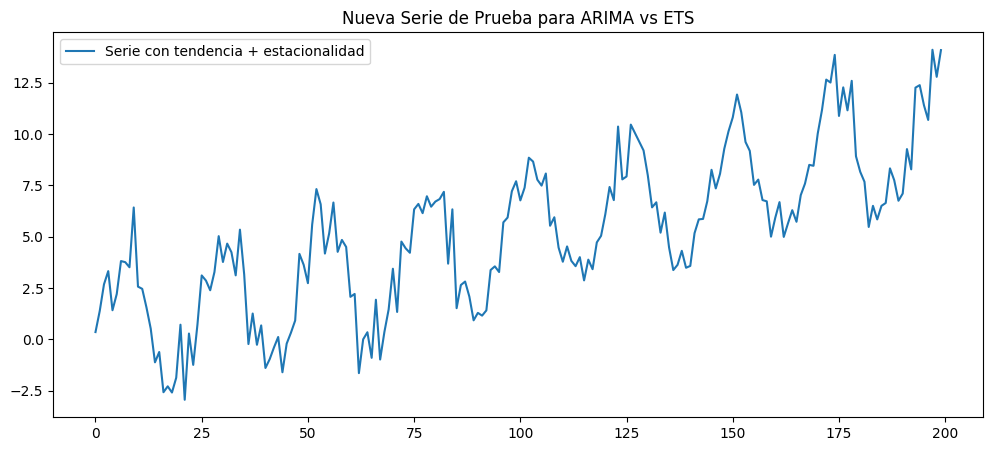

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Crear series con tendencias y estacionalidad fuerte
t = np.arange(200)
trend = 0.05 * t  # Tendencia lineal
seasonality = 3 * np.sin(2 * np.pi * t / 24)  # Estacionalidad con periodo 24
noise = np.random.normal(scale=1, size=len(t))  # Ruido aleatorio

# Serie con tendencia y estacionalidad
y_realistic = trend + seasonality + noise

# Graficar la serie
plt.figure(figsize=(12, 5))
plt.plot(y_realistic, label="Serie con tendencia + estacionalidad")
plt.title("Nueva Serie de Prueba para ARIMA vs ETS")
plt.legend()
plt.show()


In [103]:
# Aplicar auto_arima con estacionalidad
arima_real = auto_arima(y_realistic, seasonal=True, m=24, trace=True)

# Extraer (p, d, q)
print(f"Best ARIMA Order: {arima_real.order}")
###Se puede usar directamente con .predict en lugar de forecast. He estado usando el otro por dejar la llamada igual en predict_and_plot

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[24] intercept   : AIC=inf, Time=4.87 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=740.711, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=702.008, Time=0.33 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=712.171, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=739.110, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[24] intercept   : AIC=721.009, Time=0.05 sec
 ARIMA(1,1,0)(2,0,0)[24] intercept   : AIC=701.470, Time=1.19 sec
 ARIMA(1,1,0)(2,0,1)[24] intercept   : AIC=inf, Time=10.25 sec
 ARIMA(1,1,0)(1,0,1)[24] intercept   : AIC=inf, Time=2.16 sec
 ARIMA(0,1,0)(2,0,0)[24] intercept   : AIC=736.431, Time=0.80 sec
 ARIMA(2,1,0)(2,0,0)[24] intercept   : AIC=693.404, Time=1.92 sec
 ARIMA(2,1,0)(1,0,0)[24] intercept   : AIC=699.089, Time=1.13 sec
 ARIMA(2,1,0)(2,0,1)[24] intercept   : AIC=inf, Time=23.96 sec
 ARIMA(2,1,0)(1,0,1)[24] intercept   : AIC=inf, Time=9.83 sec
 ARIMA(3,1,0)(2,0,0)[24] intercept   : AIC=694.012,

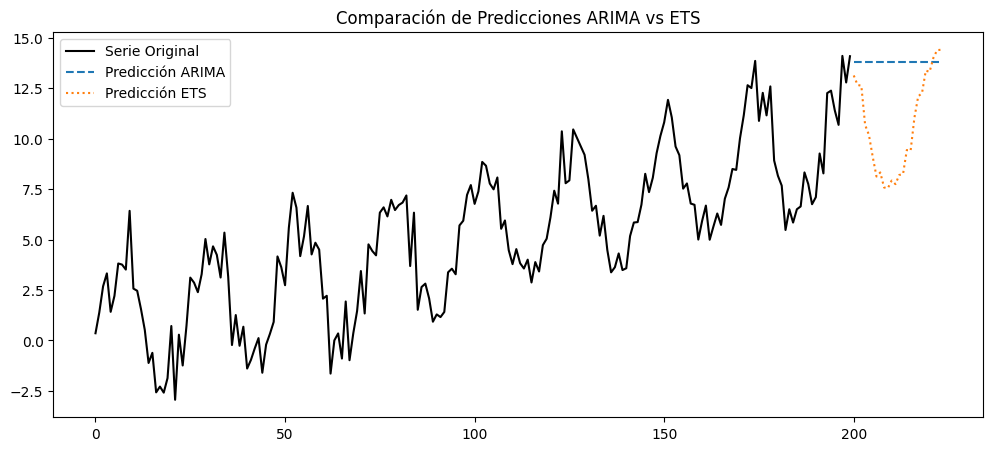

In [104]:
# Ajustar ETS con tendencia y estacionalidad
arima_real_ = ARIMA(y_realistic, order=arima_real.order).fit()
ets_real = ExponentialSmoothing(y_realistic, trend="additive", seasonal="additive", seasonal_periods=24).fit()
predict_and_plot(series_to_df(None, y_realistic), arima_real_, ets_real)

In [106]:
print(f"ARIMA AIC: {arima_real.aic()}, BIC: {arima_real.bic()}")
print(f"ETS AIC: {ets_real.aic}, BIC: {ets_real.bic}")

ARIMA AIC: 687.5538532012984, BIC: 700.7270725001963
ETS AIC: 17.98526596356964, BIC: 110.33815222691467


Gana ETS por goleada.

### ARIMA vs ETS


## ** Indicadores de que ARIMA es una buena opción**
- **La serie es o puede hacerse estacionaria**  
  - Prueba de Dickey-Fuller (*p-value* < 0.05) indica estacionariedad.  
  - La media y varianza parecen constantes en el tiempo.  
  - Se puede hacer estacionaria con diferenciación (`d` en ARIMA).  

- **Existen correlaciones en valores pasados (estructura ARMA presente)**  
  - **PACF muestra un corte brusco** en un lag → Indica presencia de AR (*p* en ARIMA).  
  - **ACF muestra un corte brusco** en un lag → Indica presencia de MA (*q* en ARIMA).  
  - Ambas funciones decrecen lentamente → Puede ser necesario un ARIMA más complejo.  

- **No hay patrones estacionales fuertes**  
  - Si la serie tiene una **estacionalidad clara y recurrente**, ARIMA puro **no es ideal**.  
  - En ese caso, se recomienda usar **SARIMA o ETS**.  

---

## **📌 Resumen**
- **Usa ARIMA si:**  
  - La serie es **estacionaria o puede hacerse estacionaria**.  
  - ACF y PACF muestran **cortes claros** que indican estructura ARMA.  
  - No hay **estacionalidad fuerte** que requiera SARIMA o ETS.  

- **Evita ARIMA si:**  
  - La serie tiene **tendencias muy marcadas que no desaparecen con diferenciación**.  
  - ACF y PACF no muestran **patrones definidos** (parecen ruido blanco).  
  - Hay **estacionalidad fuerte**, en cuyo caso SARIMA o ETS es mejor opción.  


**Other useful references**
>
>  [IMRAM ARIF - 8.16: Choosing AR(p) and MA(q) in ARIMA models using ACF and PACF] https://www.youtube.com/watch?v=_nSvoCkodS8
>
> [IMRAM ARIF - 8.18: How to pick the value of q in ARIMA models using ACF & PACF?](https://www.youtube.com/watch?v=a0BVTH86JrI)

>
> [Algoritmo para desarrollar pronósticos automáticos de series de tiempo univariadas. El índice nacional de precios al consumidor de México.](https://rev-inv-ope.pantheonsorbonne.fr/sites/default/files/inline-files/44323-05_0.pdf)